In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family = 'Malgun Gothic') # 한글 입력
plt.rcParams['axes.unicode_minus'] = False # 글꼴 변경시 마이너스 표기 가능으로 처리

In [30]:
def get_date(year=None,enddate=None):
    import datetime
    from datetime import timedelta
    import numpy as np
    import pandas as pd
    date = str(year) + '0221'
    date = datetime.datetime.strptime(date,'%Y%m%d')
    if enddate != None:
        enddate = datetime.datetime.strptime(enddate,'%Y%m%d')
    
    li = []
    stop = 0
    stop_year = date.year + 1
    while stop == 0:
        li.append(date)
        date = date + datetime.timedelta(days=1)
        if date.year == stop_year:
            stop = 1
        elif date - datetime.timedelta(days=1) == enddate:
            stop = 1
    df = pd.DataFrame(np.array(li),columns=['수주일자'])
    df.수주일자 = df.수주일자.apply(lambda x: str(x.date()))
    return df

In [31]:
df_date_21 = get_date(2021,enddate='20210421')

In [6]:
# 실제 데이터를 가져오는 사용자함수
def get_data(table_name):
    import pandas as pd
    import mariadb
    import sys

    # Connect to MariaDB Platform
    try:
        conn = mariadb.connect(
            user="root",
            password="root",
            host="localhost",
            port=3306,
            database="smart_factory"
        )
    except mariadb.Error as e:
        print(f"Error connecting to MariaDB Platform: {e}")
        sys.exit(1)
    
    # Get Cursor
    cur = conn.cursor()
    cur.execute(f"select 제품코드,수주일자,판매수량 from {table_name}")
    x = cur.fetchall()
    df = pd.DataFrame(x,columns=['제품코드','수주일자','판매수량'])
    return df

In [32]:
df_date_21

,수주일자
0,2021-02-21
1,2021-02-22
2,2021-02-23
3,2021-02-24
4,2021-02-25
5,2021-02-26
6,2021-02-27
7,2021-02-28
8,2021-03-01
9,2021-03-02


In [33]:
df_contract = get_data("`contract`")
df_contract

,제품코드,수주일자,판매수량
0,PEMA033101400,2021-02-22,15000.000000
1,PEMA023098200,2021-02-22,20000.000000
2,SSA073046500,2021-02-22,2000.000000
3,PEMA043099800,2021-02-22,10000.000000
4,PEMA013120000,2021-02-22,10000.000000
...,...,...,...
1714,PEMA043103800,2021-04-21,10000.000000
1715,PEMA023122400,2021-04-21,8000.000000
1716,PEMA353048300,2021-04-21,7000.000000
1717,TSN4012011125,2021-04-21,10000.000000


In [34]:
df_contract.drop('제품코드',axis=1,inplace=True)

In [35]:
df_contract = df_contract.groupby('수주일자').sum().reset_index()

In [36]:
df_contract.수주일자 = df_contract.수주일자.astype('str')

In [39]:
df_merged = pd.merge(df_date_21,df_contract, how='left', on='수주일자')
df_merged = df_merged.fillna(0)
df_merged.수주일자 = pd.to_datetime(df_merged.수주일자)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   수주일자    60 non-null     datetime64[ns]
 1   판매수량    60 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.4+ KB


In [53]:
# df_merged=df_merged.set_index('수주일자')
df_merged.판매수량=df_merged.판매수량.astype('float')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2021-02-21 to 2021-04-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   판매수량    60 non-null     float64
dtypes: float64(1)
memory usage: 960.0 bytes


In [40]:
# adf 검정 소스코드를 그대로 가져옴. AIC를 기준으로 검정하도록 한다.
def adf_test(timeseries):
    from statsmodels.tsa.stattools import adfuller
    import pandas as pd
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ]
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

# kpss 검정 소스코드를 그대로 가져옴. nlags는 자동으로 설정하도록 하였으나 조정이 필요한지 확인 필요
def kpss_test(timeseries):
    from statsmodels.tsa.stattools import kpss
    import pandas as pd
    import warnings
    warnings.filterwarnings('ignore')
    kpsstest = kpss(timeseries, regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    return kpss_output

In [54]:
adf_test(df_merged)

Test Statistic                 -1.534780
p-value                         0.516241
#Lags Used                      6.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64

In [55]:
kpss_test(df_merged)

Test Statistic           0.019323
p-value                  0.100000
Lags Used                1.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64

In [61]:
# 판매량 시각화 함수
def plot_df(df_merged):


    # 상품별로 데이터프레임을 뽑고 병합을 위해 우선 datetime을 문자로 변환

    df_merged.plot(figsize=(10,6))

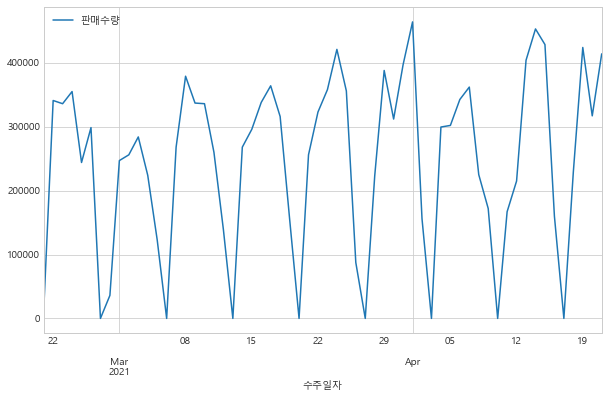

In [64]:
plot_df(df_merged)

In [74]:
# acf, pacf 시각화 함수

def df_acf_pacf(df_merged):

    fig = plt.figure(figsize=(14,6))
    fig.set_facecolor('white')
    ax1 = fig.add_subplot(121)
    sm.graphics.tsa.plot_acf(df_merged, lags=20, ax=ax1,zero=False)
    ax1.set_title('acf')
    ax2 = fig.add_subplot(122)
    sm.graphics.tsa.plot_pacf(df_merged, lags=20, ax=ax2,zero=False)
    ax2.set_title('pacf')
    plt.show()

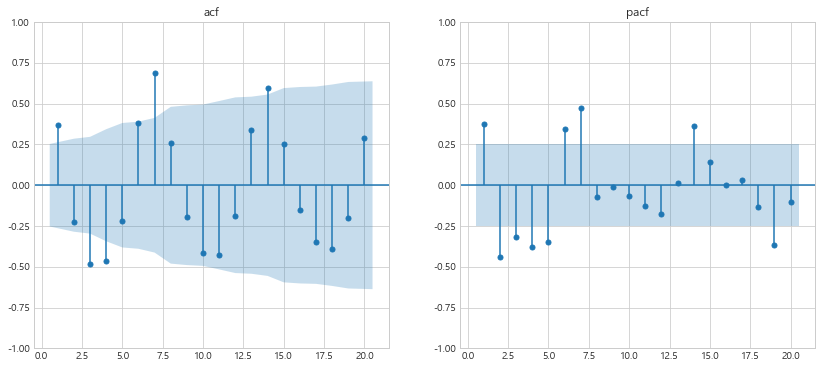

In [75]:
df_acf_pacf(df_merged)

In [80]:
# 시계열 분해 함수
def df_decomposition(df_merged):
    model_series= tsa.seasonal_decompose(df_merged, model='additive')
    # 모델 시각화
    rcParams['figure.figsize']= 15,10
    fig = model_series.plot()
    plt.show()

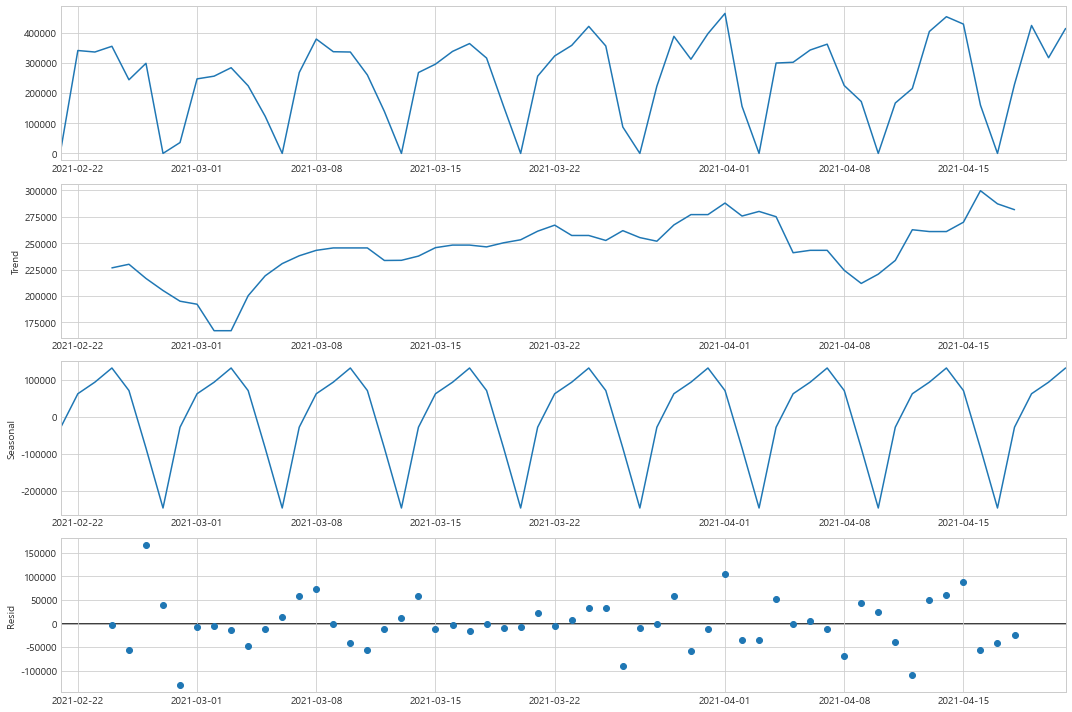

In [81]:
df_decomposition(df_merged)

In [83]:
y = df_merged['판매수량'].resample('1D').mean()

In [85]:
y

수주일자
2021-02-21     12100.0
2021-02-22    341000.0
2021-02-23    336000.0
2021-02-24    355000.0
2021-02-25    244000.0
2021-02-26    298600.0
2021-02-27         0.0
2021-02-28     36000.0
2021-03-01    247000.0
2021-03-02    256000.0
2021-03-03    284000.0
2021-03-04    224000.0
2021-03-05    123000.0
2021-03-06         0.0
2021-03-07    268000.0
2021-03-08    379000.0
2021-03-09    337000.0
2021-03-10    336000.0
2021-03-11    260000.0
2021-03-12    139000.0
2021-03-13         0.0
2021-03-14    268000.0
2021-03-15    295800.0
2021-03-16    338000.0
2021-03-17    364000.0
2021-03-18    316000.0
2021-03-19    156000.0
2021-03-20         0.0
2021-03-21    256000.0
2021-03-22    323000.0
2021-03-23    358000.0
2021-03-24    421000.0
2021-03-25    356050.0
2021-03-26     87500.0
2021-03-27         0.0
2021-03-28    223000.0
2021-03-29    388000.0
2021-03-30    312000.0
2021-03-31    397000.0
2021-04-01    464000.0
2021-04-02    156000.0
2021-04-03         0.0
2021-04-04    299500.0
2021-0

In [86]:
import itertools

In [87]:
p = d = q = range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 15) for x in list(itertools.product(p, d, q))]

In [88]:
param_list = []
param_seasonal_list = []
results_AIC_list = []

In [89]:
import statsmodels.tsa.api as tsa
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = tsa.statespace.SARIMAX(y,order=param,
                                         seasonal_order=param_seasonal,
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
            results = mod.fit()
            param_list.append(param)
            param_seasonal_list.append(param_seasonal)
            results_AIC_list.append(results.aic)
        except:
            continue

In [90]:
ARIMA_list = pd.DataFrame({'Parameter':param_list,'Seasonal':param_seasonal_list,'AIC':results_AIC_list})
ARIMA_list.to_excel('arima_model_list1.xlsx')

In [91]:
ARIMA_list.sort_values(by='AIC')

,Parameter,Seasonal,AIC
63,"(1, 1, 1)","(1, 1, 1, 15)",725.707870
59,"(1, 1, 1)","(0, 1, 1, 15)",727.977354
31,"(0, 1, 1)","(1, 1, 1, 15)",729.970517
27,"(0, 1, 1)","(0, 1, 1, 15)",730.162638
15,"(0, 0, 1)","(1, 1, 1, 15)",743.642017
...,...,...,...
33,"(1, 0, 0)","(0, 0, 1, 15)",360918.571978
13,"(0, 0, 1)","(1, 0, 1, 15)",653142.625536
9,"(0, 0, 1)","(0, 0, 1, 15)",802085.407667
5,"(0, 0, 0)","(1, 0, 1, 15)",853104.105493


In [92]:
mod = tsa.statespace.SARIMAX(y,order=(1, 0, 1),seasonal_order=(1, 0, 1, 12),
                           enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               판매수량   No. Observations:                   60
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -608.327
Date:                            Wed, 13 Apr 2022   AIC                           1226.655
Time:                                    20:16:35   BIC                           1235.798
Sample:                                02-21-2021   HQIC                          1230.080
                                     - 04-21-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9705      0.060     16.178      0.000       0.853       1.088
ma.L1          0.1174      0.208   

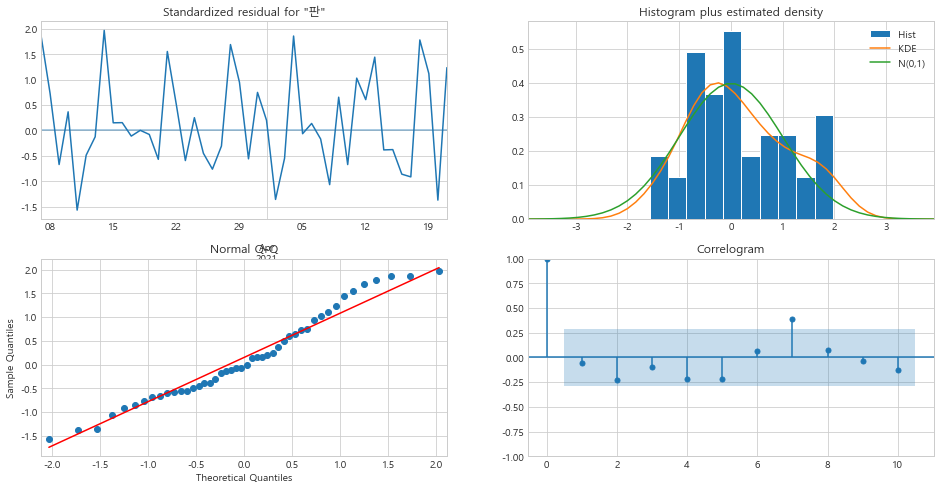

In [93]:
results.plot_diagnostics(figsize=(16,8))
plt.show()